In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import corner

from lightkurve.search import search_lightcurve

from astropy.time import Time
import astropy.units as u
import astropy.constants as c

import time as timer
tangerine= np.load('/Users/arcticfox/parula_colors.npy')[np.linspace(0,180,5,dtype=int)]

In [2]:
def normalize_lc(flux):
    #Returns median-normalized flux in units of parts-per-thousand
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3


# **TESS TICA light curve v2** 

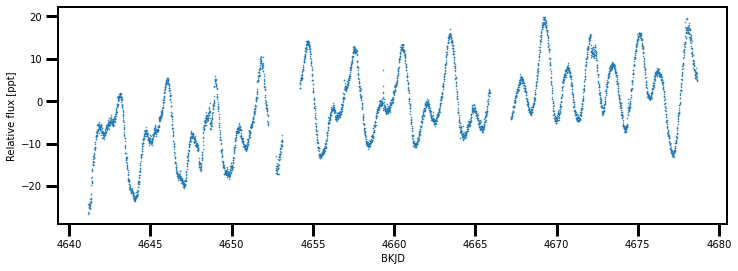

In [3]:
#From Ben on 10/17/2021
temp1 = np.loadtxt('../data/v1298_s43_o1_v2.txt')
temp2 = np.loadtxt('../data/v1298_s43_o2_v2.txt')
temp3 = np.loadtxt('../data/v1298_s44_o1_v1.txt')

temp = np.vstack((temp1, temp2, temp3))

temp[temp[:,0] > 59486,2] += 1.1e5 # hack to align offset between orbits

from astropy.time import Time
tess_mjd = temp[:,0]
tess_bjd = Time(tess_mjd, format='mjd').jd
tess_bkjd = tess_bjd - 2454833.0
tess_f1 = temp[:,2] # This is the columnn that minimizes contamination from other stars
#tess_f1 = temp[:,1] # This is the columnn that minimizes the noise in the light curve

tess_beg = tess_bkjd.min()
tess_end = tess_bkjd.max()
tess_mission_flag = ['tess']*len(tess_bkjd)
tess_texp = np.median(np.diff(tess_bkjd))

x = tess_bkjd
y = normalize_lc(tess_f1)
y[-len(temp3[:,2]):] -= 59

# light time travel correction
from astropy import time, coordinates as coord, units as u

greenwich = coord.EarthLocation.of_site('greenwich')
times = time.Time(tess_bjd, format='jd', location=greenwich)
moon = coord.get_moon(times)

delta_time = times.light_travel_time(moon)

corr_x = times.value + delta_time.value - 2454833


x = np.ascontiguousarray(corr_x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)

mission_flag = tess_mission_flag

plt.plot(x,y,'.',ms=1)
plt.xlabel("BKJD")
plt.ylabel("Relative flux [ppt]")
plt.gcf().set_size_inches(12,4)
plt.show()

In [4]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

include_planet_e = True

if include_planet_e == True:    
    
    #Livingston ephemeris
    t0s     = np.array([2231.281202 - 0.75*4.66/24, 
                              2239.400529 + 0.5*5.59/24, 
                              2234.046461 - 0.5*6.42/24, 
                              2263.6229, 4644.08])
    periods = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445, 30.15])    

    rors    = np.array([0.0381, 0.0436, 0.0700, 0.0611, 0.06])
    depths  = np.array(1e3*(rors**2))
    t14s    = np.array([4.66, 5.59, 6.42, 7.45, 7.5])/24.0

elif include_planet_e == False:
    t0s     = np.array([2231.281202, 2239.400529, 2234.046461])# - x_ref
    periods = np.array([8.249147, 12.401369,  24.141445])
    rors    = np.array([0.0381, 0.0436, 0.0700])
    depths  = np.array(1e3*(rors**2))    

# Number of planets to be included in fit
n_pl = len(t0s)

# Compute the expected transit times for a linear ephemeris
expected_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    x.min(), x.max(), periods, t0s
)

### Before we start fitting the light curve let's see if we can identify the transits by eye

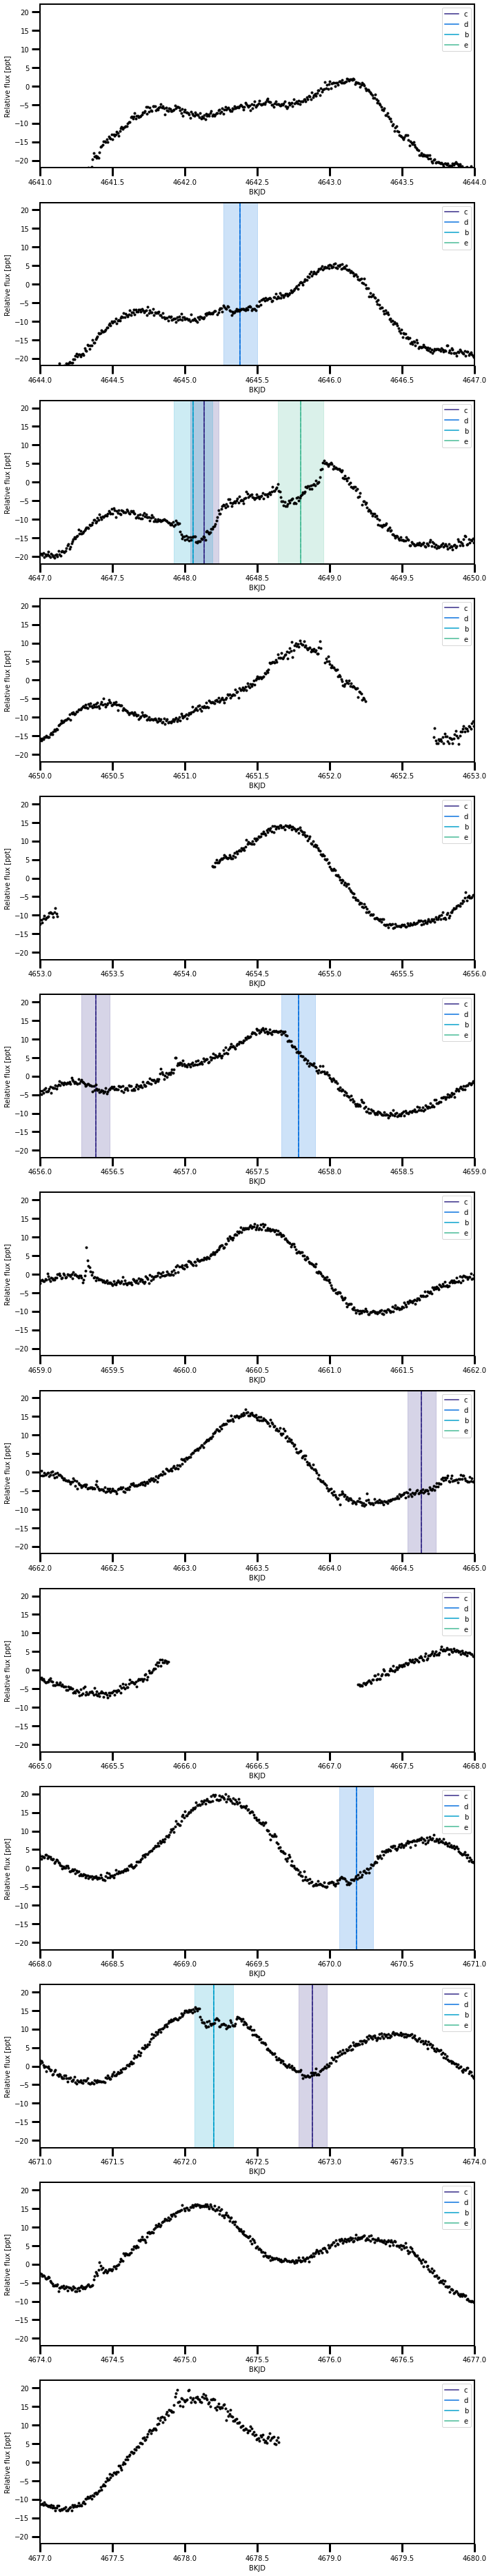

In [5]:
nrows = 13
xmin = int(tess_bkjd.min()) + 3*np.arange(nrows)

fig,axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,4*nrows))

for n in range(nrows):
    ax = axes[n]

    for i,let in enumerate("cdbe"):
        ttimes = expected_transit_times[i]
        for j,_tt in enumerate(ttimes):
            if (_tt>tess_bkjd.min()) & (_tt<tess_bkjd.max()):
                ax.axvline(_tt, color=tangerine[i], label=let)
                ax.axvspan(_tt-0.5*t14s[i], _tt+0.5*t14s[i], 
                           alpha=0.2, color=tangerine[i])
                ax.axvline(_tt, color=tangerine[i], ls='--') # planet c

    ax.plot(x, y, 'k.')
    #ax.plot(tica2_bkjd, tica2_f1, 'k.')
    #ax.plot(tica2_bkjd, tica2_f2, 'k.')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


    ax.set_xlim(xmin[n], xmin[n]+3)
    ax.set_ylim(-22,22)
    ax.set_xlabel("BKJD")
    ax.set_ylabel("Relative flux [ppt]")

plt.tight_layout()
plt.show()

It looks like: 

1. Planet d arrives late at BKJD = 4645.4
2. Planet b arrives early at BKJD = 4648.1
3. Planet c arrives late at BKJD = 4648.53? There is a dip right before the ingress of planet e, with seemingly the right duration. It's hard to tell for sure because the noise changes significantly around the transit.
4. Planet e transits around BKJD = 4648.8 


The data beyond BKJD = 4651.5 are corrupted so let's remove it.

# **The SimpleTransitOrbit model** (fitting in terms of duration)


In [6]:
ett = np.array([expected_transit_times[0][0],
               expected_transit_times[1][0],
               expected_transit_times[2][0],
                expected_transit_times[3][0],
               ])
ett

array([4648.135648  , 4645.38257333, 4648.057211  , 4648.8       ])

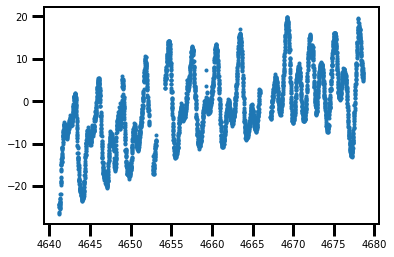

In [7]:
periods   = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445])    
t0s       = np.round(ett,2)+0.0# #np.array([4648.14, 4645.4, 4648.1, 4648.8])
rors      = np.array([0.0381, 0.0436, 0.0700, 0.0611])
depths    = np.array(1e3*(rors**2))
durations = np.array([4.66, 5.59, 6.42, 7.45])/24.0
n_pl      = len(periods)
R_star    = 1.305, 0.07

#x = tica2_bkjd
#y = tica2_f1

m = (np.isfinite(x)) & (np.isfinite(y))# & (x<4651.5)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

plt.plot(x,y,'.')

In [8]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

# Required changes:
# We can have different depths for K2 and TESS


def build_model(mask=None, 
                start=None,
                ttvs=False,
                eccentric=False):
    
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
        
        #log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), sigma=2.0, shape=n_pl)                
        log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), 
                                   sigma=0.1, shape=n_pl)                        
        ror_tess = pm.Deterministic("ror_tess", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_tess), b
                                    ),
                                   )
                    
        r_pl_tess = pm.Deterministic("r_pl_tess", ror_tess * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror_tess * r_star * c.R_sun/c.R_earth)

        ecc = np.zeros(n_pl)
        omega = np.pi/2*np.ones(n_pl)

            
        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=n_pl)
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=n_pl)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        ########################################################################################        
        ########################################################################################
        # Compute the model light curve
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        
        # Quadratic trend for varying background flux
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )
        # Define the background model
        A = np.vander(x, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))        
        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_tess, 
                t=x[mask], 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess
        resid_tess = y[mask] - light_curve_tess - bkg[mask]

        # Transit jitter & GP parameters
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(y[mask])), sd=10)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(y[mask])), sd=10) 
        yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess))
                
        #The parameters of the RotationTerm kernel
        sigma_rot_tess = pm.InverseGamma(
            "sigma_rot_tess", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period_rot_tess = pm.Normal("log_period_rot_tess", mu=np.log(2.87), sigma=2.0)
        period_rot_tess = pm.Deterministic("period_rot_tess", tt.exp(log_period_rot_tess))
        log_Q0_rot_tess = pm.HalfNormal("log_Q0_rot_tess", sigma=2.0)
        log_dQ_rot_tess = pm.Normal("log_dQ_rot_tess", mu=0.0, sigma=2.0)
        f_rot_tess = pm.Uniform("f_rot_tess", lower=0.1, upper=1.0)

        kernel_tess = terms.RotationTerm(
                    sigma=sigma_rot_tess,
                    period=period_rot_tess,
                    Q0=tt.exp(log_Q0_rot_tess),
                    dQ=tt.exp(log_dQ_rot_tess),
                    f=f_rot_tess,
                )

        gp_tess = GaussianProcess(kernel_tess, t=x[mask], yerr=yerr_tess)
        gp_tess.marginal("transit_obs_tess", observed=resid_tess)        

        #Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * tt.stack(
                [
                    star.get_light_curve(
                        orbit=orbit, r=r_pl_tess, t=t0[n] + phase_lc, texp=tess_texp
                    )[..., n]
                    for n in range(n_pl)
                ],
                axis=-1,
            ),
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        
        map_soln = pmx.optimize(start=start, 
                                vars=trend)
        
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[b,
                                      log_depth_tess])
        
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[sigma_rot_tess,
                                      log_period_rot_tess,
                                      log_Q0_rot_tess,
                                      log_dQ_rot_tess,
                                      f_rot_tess,
                                      mean_tess,
                                      ]
                               )
        
        
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves_tess", 
                 "gp_pred_tess"],
                pmx.eval_in_model([light_curves_tess,
                                   gp_tess.predict(resid_tess)], map_soln),
            )
        )

    return model, map_soln, extras, orbit

model0, map_soln0, extras0, orbit0 = build_model(ttvs=False)

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -88658.41328786885 -> -87362.73684242746
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -87362.73684242746 -> -85170.6986747179
optimizing logp for variables: [log_depth_tess, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -85170.6986747179 -> -83906.0990275992
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


message: Desired error not necessarily achieved due to precision loss.
logp: -83906.0990275992 -> -5112.82076067916
optimizing logp for variables: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, trend, mean_tess, log_period, t0, log_depth_tess, b, u_star, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -5112.82076067916 -> -4828.123168510008


<ErrorbarContainer object of 3 artists>

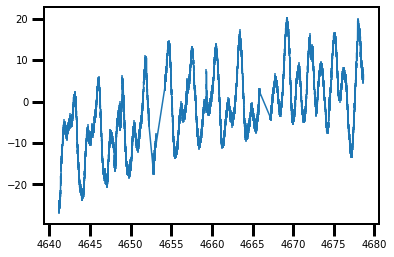

In [9]:
yerr_tess = np.ascontiguousarray(map_soln0['yerr_tess'] + 0.0, dtype=np.float64)
plt.errorbar(x,y,yerr=yerr_tess)

In [26]:
def depth_duration_model(ttvs=False):

    with pm.Model() as model:

        # Physical parameters that will be sampled
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])  
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
        #t0 = pm.Normal("t0", mu=t0s, sigma=0.1, shape=n_pl)
        
        #log_period = pm.Normal("log_period", mu=np.log(periods), 
        #                       sigma=0.1, shape=n_pl)
        
        
        log_depth = pm.Normal("log_depth", mu=np.log(depths), 
                              sigma=0.1, shape=n_pl)
        log_duration = pm.Normal("log_duration", mu=np.log(durations), 
                                 sigma=0.1, shape=n_pl)

        # Track parameters of interest as deterministics
        duration = pm.Deterministic("duration", tt.exp(log_duration))
        ror = pm.Deterministic("ror", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth), b
                                    ),
                                    )
        r_pl_tess = pm.Deterministic("r_pl_tess", ror * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror * r_star * c.R_sun/c.R_earth)  
        
        ecc = np.zeros(n_pl)
        omega = np.pi/2*np.ones(n_pl)

        if ttvs==True:
            # Now we have a parameter for each transit time of each planet:
            transit_times = []
            for i in range(n_pl):
                transit_times.append(
                    pm.Normal(
                        "tts_{0}".format(i),
                        mu=expected_transit_times[i],
                        sd=1.0, #Change this back to 0.1 to work
                        shape=len(expected_transit_times[i]),
                    )
                )

            # Set up an orbit for the planets
            orbit = xo.orbits.TTVOrbit(
                r_star=r_star,
                m_star=m_star,
                b=b,
                ecc=ecc,
                omega=omega,
                transit_times=transit_times)

            # It will be useful later to track some parameters of the orbit
            t0 = pm.Deterministic("t0", orbit.t0)
            period = pm.Deterministic("period", orbit.period)
            log_period = pm.Normal("log_period", mu=np.log(periods), 
                               sigma=0.1, shape=n_pl)
            for i in range(n_pl):
                pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
            #period = pm.Deterministic("period", tt.exp(log_period))
            
        elif ttvs==False:
            
            # Orbital parameters for the planets
            t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=n_pl)
            log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=n_pl)
            period = pm.Deterministic("period", tt.exp(log_period))

            # Orbit models
            orbit = xo.orbits.KeplerianOrbit(
                r_star=r_star,
                m_star=m_star,
                period=period,
                t0=t0,
                b=b,
                ecc=ecc,
                omega=omega,
            )


        # Quadratic trend for varying background flux
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )
        # Define the background model
        A = np.vander(x, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))     
        
        #Compute the light curve model
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_tess, 
                t=x, 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess
        resid_tess = y - light_curve_tess - bkg
        
        # Transit jitter & GP parameters
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(y)), 
                                       sd=5)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(y)), 
                                       sd=5) 
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess))
                
        #The parameters of the RotationTerm kernel
        sigma_rot_tess = pm.InverseGamma(
            "sigma_rot_tess", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period_rot_tess = pm.Normal("log_period_rot_tess", mu=np.log(2.87), sigma=2.0)
        period_rot_tess = pm.Deterministic("period_rot_tess", tt.exp(log_period_rot_tess))
        log_Q0_rot_tess = pm.HalfNormal("log_Q0_rot_tess", sigma=2.0)
        log_dQ_rot_tess = pm.Normal("log_dQ_rot_tess", mu=0.0, sigma=2.0)
        f_rot_tess = pm.Uniform("f_rot_tess", lower=0.1, upper=1.0)

        kernel_tess = terms.RotationTerm(
                    sigma=sigma_rot_tess,
                    period=period_rot_tess,
                    Q0=tt.exp(log_Q0_rot_tess),
                    dQ=tt.exp(log_dQ_rot_tess),
                    f=f_rot_tess,
                )

        gp = GaussianProcess(kernel_tess, t=x, yerr=yerr_tess)
        gp.marginal("transit_obs", observed=resid_tess)  


        # Compute and save the phased light curve models
        if ttvs == False:
            pm.Deterministic(
                "lc_pred_tess",
                1e3
                * tt.stack(
                    [
                        star.get_light_curve(
                            orbit=orbit, r=r_pl_tess, t=t0[n] + phase_lc, 
                            texp=tess_texp
                        )[..., n]
                        for n in range(n_pl)
                    ],
                    axis=-1,
                ),
            )  

        # Perform optimization
        start = model.test_point
        map_soln = pmx.optimize(start=start, 
                                vars=trend)
        
        if ttvs==True:
            map_soln = pmx.optimize(start=map_soln, vars=transit_times)
        elif ttvs==False:
            map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[b,
                                      log_depth])
        if ttvs == True:
            map_soln = pmx.optimize(start=map_soln, vars=transit_times)
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[sigma_rot_tess,
                                      log_period_rot_tess,
                                      log_Q0_rot_tess,
                                      log_dQ_rot_tess,
                                      f_rot_tess,
                                      mean_tess,
                                      ]
                               )
        
        
        map_soln = pmx.optimize(start=map_soln)

        # Package the MAP light curve and GP prediction
        extras = dict(
            zip(
                ["light_curves_tess", 
                  "gp_pred_tess"],
                pmx.eval_in_model([light_curves_tess,
                                    gp.predict(resid_tess)], map_soln),
            )
        )

    return model, map_soln, extras, orbit


model1, map_soln1, extras1, orbit1 = depth_duration_model(ttvs=True)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
optimizing logp for variables: [trend]


//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: invalid value encountered in double_scalars
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
message: Desired error not necessarily achieved due to precision loss.
logp: -8082.8661837879245 -> -6782.756053508397
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in double_scalars
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in true_divide
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
WARNING (theano.tensor.opt): Cannot construct a scalar

message: NaN result encountered.
logp: -6782.756053508397 -> -6782.756053508397
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
optimizing logp for variables: [log_depth, b]


message: NaN result encountered.
logp: -6782.756053508397 -> -6782.756053508397
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
optimizing logp for variables: [tts_3, tts_2, tts_1, tts_0]


message: NaN result encountered.
logp: -6782.756053508397 -> -6782.756053508397
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: invalid value encountered in double_scalars
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
message: Desired error not necessarily achieved due to precision loss.
logp: -6782.756053508397 -> -5111.386449470195
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in double_scalars
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in true_divide
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
WARNING (theano.tensor.opt): Cannot construct a scalar 

message: NaN result encountered.
logp: -5111.386449470195 -> -5111.386449470195
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0


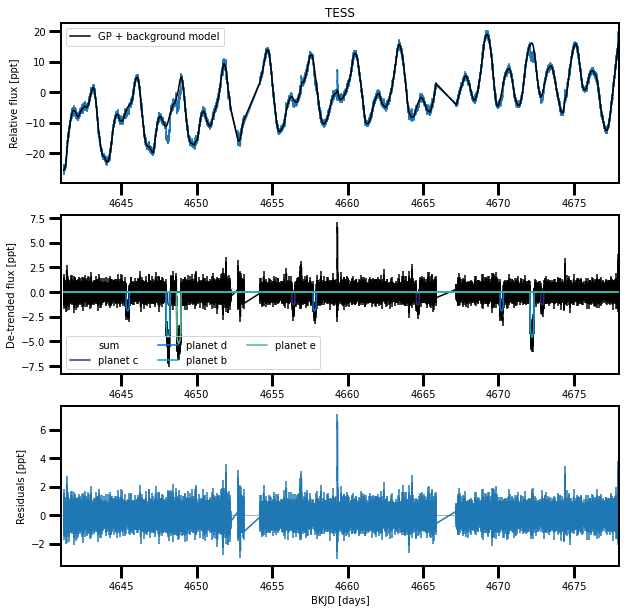

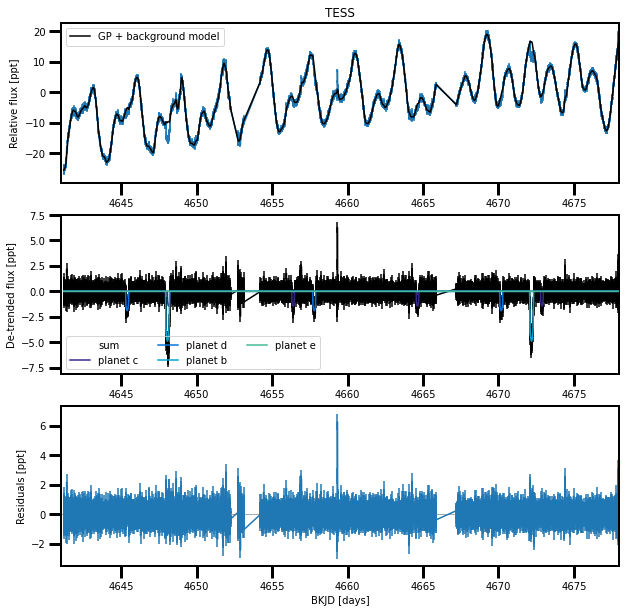

In [27]:
def plot_light_curve(soln, extras, xrange=[4641,4678], mask=None):


    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

        
    ax = axes[0]
    ax.errorbar(x[mask], y[mask], yerr=yerr_tess)#soln["yerr_tess"])
    gp_mod = extras["gp_pred_tess"] + soln["mean_tess"] + soln["bkg"]
    ax.plot(x[mask], gp_mod, color="k", label="GP + background model", zorder=4)
    ax.legend(fontsize=10, ncol=2)
    ax.set_ylabel("Relative flux [ppt]")
    
    ax.set_title('TESS')

    ax = axes[1]
    ax.errorbar(x[mask], y[mask] - gp_mod, yerr=yerr_tess,color='k')#soln["yerr_tess"])

    mod_sum = np.sum(extras["light_curves_tess"], axis=-1)
    ax.plot(x[mask], mod_sum, label="sum", color="w")
    
    for i, l in enumerate("cdbe"):
        mod = extras["light_curves_tess"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l), zorder=3,
                color=tangerine[i])
        
    
        
    ax.legend(fontsize=10, loc=3, ncol=3)
    ax.set_ylabel("De-trended flux [ppt]")
    

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves_tess"], axis=-1)
    ax.errorbar(x[mask], y[mask] - mod, yerr=yerr_tess)#soln["yerr_tess"])
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals [ppt]")
    ax.set_xlabel("BKJD [days]")
    
    for i in range(3):
        axes[i].set_xlim(xrange[0],xrange[1])
    

    return fig
 

_ = plot_light_curve(map_soln0, extras0)
_ = plot_light_curve(map_soln1, extras1)

In [28]:
with model1:
    trace_ex = pmx.sample(tune=500,
                          draws=5000,
                          start=map_soln1,
                          chains=3,
                          return_inferencedata=True,
                          random_seed=[39248934, 48374109, 84738013])
trace_ex.to_dataframe().to_csv('summary_ttvs.csv')

//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in double_scalars
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py:5435: RuntimeWarning: divide by zero encountered in true_divide
  v = reduce(np.multiply, num, one) / reduce(np.multiply, denum, one)
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  va

Sampling 3 chains for 500 tune and 5_000 draw iterations (1_500 + 15_000 draws total) took 109 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{int64::}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Subtensor{:int64:}.0
//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning s

In [29]:
flat_samps = trace_ex.posterior.stack(sample=("chain", "draw"))
summ = az.summary(trace_ex)

//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
arviz - WARNING - Array contains NaN-value.


In [30]:
for i in range(0,4):
    print(i)
    for j in range(len(flat_samps['tts_{}'.format(i)])):
        med = np.nanmedian(flat_samps['tts_{}'.format(i)][j].data)
        upp = np.nanpercentile(flat_samps['tts_{}'.format(i)][j].data,84)
        low = np.nanpercentile(flat_samps['tts_{}'.format(i)][j].data, 16)
        u = np.round(upp,4)
        l = np.round(low,4)
        m = np.round(med, 4)
        print(l,u,m)

0
4648.1356 4648.1356 4648.1356
4656.3848 4656.3848 4656.3848
4664.6339 4664.6339 4664.6339
4672.8831 4672.8831 4672.8831
1
4645.3826 4645.3826 4645.3826
4657.7839 4657.7839 4657.7839
4670.1853 4670.1853 4670.1853
2
4648.0572 4648.0572 4648.0572
4672.1987 4672.1987 4672.1987
3
4648.8 4648.8 4648.8


In [31]:
np.nanmedian(flat_samps['t0'][0]) , np.nanpercentile(flat_samps['t0'][0],16)

(4648.135648000001, 4648.135648000001)